# Importamos

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import pandas as pd 
import numpy as np
import sklearn as sk
import seaborn as sns
import pydotplus
from six import StringIO
from IPython.display import Image  
from matplotlib import pyplot as plt
#TODO creo q no va:
from dict_paises import COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2, COUNTRY_ALPHA2_TO_CONTINENT
from joblib import dump, load
from os.path import exists

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import confusion_matrix, classification_report , f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score



#Si estamos  en colab tenemos que instalar la libreria "dtreeviz" aparte. 
if IN_COLAB == True:
    !pip install 'dtreeviz'
import dtreeviz as dtreeviz

#Para eliminar los warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

from keras.wrappers.scikit_learn import KerasClassifier #Libreria para usarg Grid Search con kerss

Constantes

In [2]:
# Constantes
JOBS=-2
SEED=9

np.random.seed(SEED)
tf.random.set_seed(SEED) 

importo el dataframe original para tener los ids

In [3]:
hotelsdf_pruebasOriginal = pd.read_csv("./hotels_test.csv")

Importamos los dataframes ya filtrados que generamos en el checkpoint 1. De esta forma evitamos tener todo el codigo de homologacion de dataframes de testeo y train aqui de nuevo

In [4]:
hotelsdf_train_filtrado = pd.read_csv("hotels_filtrado_train.csv")
hotelsdf_testeo_filtrado = pd.read_csv("hotels_filtrado_test.csv")

In [5]:
set_test = set(hotelsdf_testeo_filtrado.columns)
set_modelo = set(hotelsdf_train_filtrado.columns)

missing = list(sorted(set_test - set_modelo))
added = list(sorted(set_modelo - set_test))

print('Faltan en arbol:', missing)
print('Sobran en arbol:', added)

Faltan en arbol: []
Sobran en arbol: ['is_canceled']


Guardo datos antes de separacion train test

# Generacion de datos para el entrenamiento de los modelos

Se genera un dataset con los datos necesarios para predecir la cancelacion y creamos un dataset conteniendo el target, para luego, generar conjuntos de test y train

In [6]:
hotelsdf_modelo_x=hotelsdf_train_filtrado.drop(['is_canceled'], axis='columns', inplace=False)

hotelsdf_modelo_y = hotelsdf_train_filtrado['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(hotelsdf_modelo_x,
                                                    hotelsdf_modelo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=SEED) #Semilla 9, como el Equipo !!

Buscamos los valores que no fueron generados por el one hot encoder

In [7]:
x_train.columns

Index(['lead_time', 'arrival_year', 'arrival_week_number', 'arrival_month_day',
       'weekend_nights_num', 'week_nights_num', 'adult_num', 'children_num',
       'babies_num', 'is_repeated_guest', 'previous_cancellations_num',
       'booking_changes_num', 'agent_id', 'days_in_waiting_list',
       'average_daily_rate', 'required_car_parking_spaces_num',
       'special_requests_num', 'dias_totales', 'hotel_name_Resort Hotel',
       'arrival_month_August', 'arrival_month_December',
       'arrival_month_February', 'arrival_month_January', 'arrival_month_July',
       'arrival_month_June', 'arrival_month_March', 'arrival_month_May',
       'arrival_month_November', 'arrival_month_October',
       'arrival_month_September', 'meal_type_FB', 'meal_type_HB',
       'meal_type_SC', 'meal_type_Undefined',
       'market_segment_type_Complementary', 'market_segment_type_Corporate',
       'market_segment_type_Direct', 'market_segment_type_Groups',
       'market_segment_type_Offline TA/TO',

In [8]:
valoresNoBinarios = ['lead_time', 'arrival_year', 'arrival_week_number', 'arrival_month_day',
       'weekend_nights_num', 'week_nights_num', 'adult_num', 'children_num',
       'babies_num', 'previous_cancellations_num',
       'booking_changes_num', 'days_in_waiting_list',
       'average_daily_rate', 'required_car_parking_spaces_num',
       'special_requests_num', 'dias_totales']

Imports para armar la red

Tenemos que escalar todos los valores de nuestro data set (excepto los valores producidos por el one hot encoding

In [9]:
sScaler = StandardScaler()
sScaler.fit(pd.DataFrame(x_train[valoresNoBinarios]))

StandardScaler()

In [10]:
x_train_transform_1=sScaler.transform(pd.DataFrame(x_train[valoresNoBinarios]))
x_test_transform_1=sScaler.transform(pd.DataFrame(x_test[valoresNoBinarios]))

In [11]:
x_train_transform_1

array([[-0.08993302,  1.20492525, -1.05091228, ..., -0.22125409,
         1.98006251, -0.19194279],
       [-0.04922764,  1.20492525,  0.43392148, ..., -0.22125409,
         0.64636577,  1.6108728 ],
       [ 0.3680026 ,  1.20492525, -0.38273709, ..., -0.22125409,
         1.98006251, -0.19194279],
       ...,
       [-0.10010937, -0.20168049, -0.60546216, ..., -0.22125409,
        -0.68733097, -1.09335058],
       [-0.35451805, -0.20168049,  0.35967979, ..., -0.22125409,
         0.64636577, -0.64264669],
       [-0.76157194, -1.60828624,  1.10209667, ..., -0.22125409,
         1.98006251,  1.16016891]])

In [12]:
#Creamos un nuevo dataframe con los valores escalados
x_train_escalado = x_train.copy()
x_test_escalado = x_test.copy()

In [13]:
#Le asignamos los nuevos valores escalados y mantenemos los valores del one hot encoding
for i in range(len(valoresNoBinarios)):
    x_train_escalado[valoresNoBinarios[i]]=x_train_transform_1[:,i]
    x_test_escalado[valoresNoBinarios[i]]=x_test_transform_1[:,i]

In [14]:
x_train_escalado

,lead_time,arrival_year,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,babies_num,is_repeated_guest,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,continente_Asia,continente_Europe,continente_North America,continente_Oceania,continente_South America
15425,-0.089933,1.204925,-1.050912,1.728338,0.078225,-0.297259,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
42050,-0.049228,1.204925,0.433921,0.022526,1.145264,1.489213,2.437582,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
25055,0.368003,1.204925,-0.382737,-1.683286,-0.988814,0.298231,2.437582,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
619,1.182110,1.204925,-0.308495,-1.114682,-0.988814,-0.297259,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
30470,0.011830,-0.201680,0.582405,0.932292,-0.988814,0.893722,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42747,-1.097391,-0.201680,0.582405,1.046013,-0.988814,-0.892750,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
22584,-0.232402,1.204925,0.062713,-0.432357,-0.988814,-0.297259,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
501,-0.100109,-0.201680,-0.605462,-1.000961,-0.988814,-0.892750,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
55934,-0.354518,-0.201680,0.359680,-1.114682,0.078225,-0.892750,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0


In [15]:
x_test_escalado

,lead_time,arrival_year,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,babies_num,is_repeated_guest,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,continente_Asia,continente_Europe,continente_North America,continente_Oceania,continente_South America
52715,-0.517340,1.204925,-1.050912,1.500896,0.078225,0.893722,0.263118,-0.250952,11.674810,0,...,0,0,0,1,0,0,1,0,0,0
40651,2.087805,-1.608286,0.582405,1.159734,-0.988814,-0.297259,0.263118,-0.250952,-0.082681,0,...,1,0,0,0,1,0,1,0,0,0
39785,0.541001,-0.201680,-1.050912,1.046013,0.078225,-0.297259,0.263118,-0.250952,-0.082681,0,...,1,0,0,1,0,0,1,0,0,0
56079,0.805586,1.204925,-0.456979,1.273454,1.145264,-0.892750,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
47980,2.515212,-1.608286,1.027855,-1.000961,-0.988814,-0.297259,0.263118,-0.250952,-0.082681,0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41901,-1.087215,-0.201680,0.211196,0.591130,-0.988814,-0.892750,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0
42804,1.741809,-0.201680,1.102097,-0.432357,-0.988814,0.298231,0.263118,-0.250952,-0.082681,0,...,1,0,0,1,0,0,1,0,0,0
22168,-1.015981,-0.201680,-1.273637,-1.569565,-0.988814,-0.892750,-1.911346,-0.250952,-0.082681,0,...,0,0,0,0,1,0,1,0,0,0
36851,-0.720867,1.204925,0.062713,-0.773519,1.145264,-1.488240,0.263118,-0.250952,-0.082681,0,...,0,0,0,1,0,0,1,0,0,0


In [16]:
cant_clases = 1


#d_in=len(y_train)
d_in=len(x_train_escalado.columns)

modelo_hotels_1 = keras.Sequential([
    keras.layers.Dense(8,input_shape=(d_in,),activation ='relu'),
    keras.layers.Dense(cant_clases, activation='sigmoid'),
])


modelo_hotels_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 560       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 569
Trainable params: 569
Non-trainable params: 0
_________________________________________________________________


In [17]:
modelo_hotels_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.1), 
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs=10

historia_modelo_hotel_1=modelo_hotels_1.fit(x_train_escalado,y_train,epochs=cant_epochs,batch_size=16,verbose=False)

534/534 [==============================] - 0s 631us/step


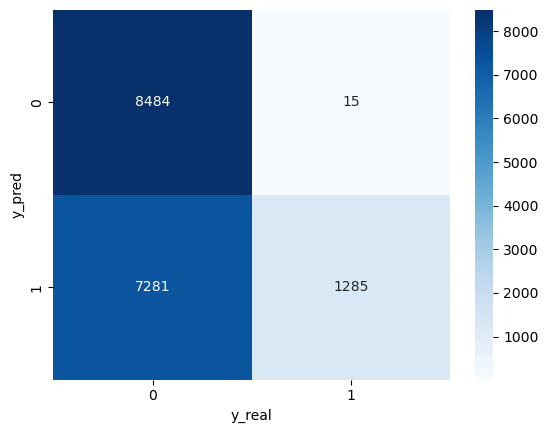

In [18]:
y_pred = modelo_hotels_1.predict(x_test_escalado)
y_predic_cat_ej1 = np.where(y_pred>0.7,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues', fmt='g')
plt.show()

In [19]:
if not exists('submissions/red_neuronal_basica.csv'):
    y_pred_testeo = modelo_hotels_1.predict(hotelsdf_testeo_filtrado)
    y_pred_testeo_cat = np.where(y_pred_testeo>0.70,1,0)
    df_resultados_pred = pd.DataFrame.from_records(y_pred_testeo_cat,columns = ["resultado"])
    df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': df_resultados_pred["resultado"]})
    df_submission.to_csv('submissions/red_neuronal_basica.csv', index=False)

# Validacion cruzada

En esta etapa vamos a realizar unas series de validaciones cruzadas en la busqueda de encontrar el mejor resultado

Para usar la libreria Keras Classifier necesitamos crear una funcion que cree una modelo.

In [20]:
loss='binary_crossentropy'
metrics=['AUC']
optimizer="adam"

def creador_modelo(learning_rate = 0.1, 
                   activation = 'sigmoid', 
                   output = 2, 
                  hidden_layers = 2
                  ):
    model = keras.Sequential()
    model.add(keras.layers.Dense(5, activation=activation, input_shape=(d_in,)))
    
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(output, activation=activation))

    model.add(keras.layers.Dense(1, activation=activation))
    
    model.compile(
      optimizer=optimizer,
      loss=loss, 
      metrics=metrics, 
    )
    return model

Vamos a empezar con una baja cantidad de epochs y batch_size

In [21]:
model = KerasClassifier(build_fn=creador_modelo, 
                        verbose=1)

/tmp/ipykernel_6135/2109703127.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [22]:
param_grid = { 
                  "hidden_layers" : [1, 5, 10, 15, 20], 
                    "output" : [1, 2, 4, 8, 32, 64], 
                    "batch_size" : [5, 10, 20],
                    "epochs" : [50, 100, 150],
                   "activation": ["sigmoid", "relu", "softmax", "softplus", "elu", ]
             } 

In [23]:
rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_jobs=JOBS, cv=3,n_iter=10)

In [24]:
if exists('modelos/rs_fit.joblib') == False:
    rs_fit = rs.fit(X = x_train_escalado, y = y_train)
    dump(rs_fit, 'modelos/rs_fit.joblib')
else:
    rs_fit = load('modelos/rs_fit.joblib')

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-05-25 21:37:40       270264
config.json                                    2023-05-25 21:37:40         7766
metadata.json                                  2023-05-25 21:37:40           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_10
.........vars
............0
............1
......dense_11
.........vars
............0
............1
......dense_12
.........vars
............0
............1
......dense_13
.........vars
............0
............1
......dense_14
.........vars
............0
............1
......dense_15
.........vars
............0
............1
......dense_16
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dens

In [25]:
rs_fit.best_params_

{'output': 32,
 'hidden_layers': 15,
 'epochs': 50,
 'batch_size': 10,
 'activation': 'relu'}

In [29]:
modelo_rs = keras.Sequential()
modelo_rs.add(keras.layers.Dense(5, activation=rs_fit.best_params_["activation"], input_shape=(d_in,)))
    
for i in range(rs_fit.best_params_["hidden_layers"]):
        # Add one hidden layer
    modelo_rs.add(keras.layers.Dense(rs_fit.best_params_["output"], activation=rs_fit.best_params_["activation"]))

modelo_rs.add(keras.layers.Dense(1, activation="sigmoid"))

    
modelo_rs.compile(
#     optimizer=keras.optimizers.SGD(learning_rate=rs_fit.best_params_["learning_rate"]), 
    optimizer=optimizer,
    loss=loss, 
    metrics=metrics, 
    )

In [30]:
# cant_epochs=10
cant_epochs=rs_fit.best_params_["epochs"]
batch_size=rs_fit.best_params_["batch_size"]

historia_modelo_hotel_2=modelo_rs.fit(x_train_escalado,y_train,
                                      epochs=cant_epochs,
                                      batch_size=batch_size,verbose=False)


534/534 [==============================] - 1s 759us/step


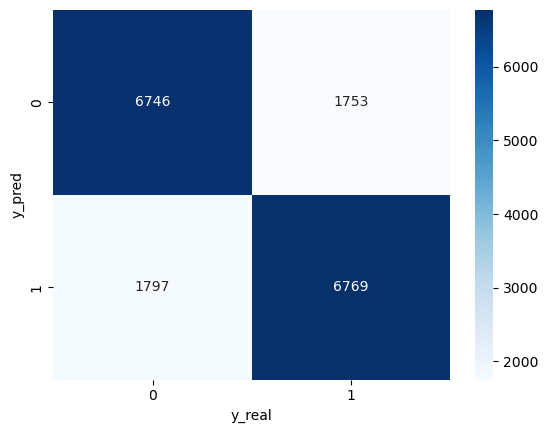

In [31]:
y_pred = modelo_rs.predict(x_test_escalado)
y_predic_cat_ej1 = np.where(y_pred>0.5,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues', fmt='g')
#plt.ticklabel_format(style='plain', axis='both')
plt.show()